In [1]:
# example of a dcgan on cifar10
from numpy import ones
from numpy.random import randint, randn
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import LeakyReLU, Conv2D, Conv2DTranspose, Embedding, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets.cifar10 import load_data

 
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3), n_classes=10):
    # Label input
    label_input = Input(shape=(1,))
    li = Embedding(n_classes, 50)(label_input)
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    li = Reshape((in_shape[0], in_shape[1], 1))(li)

    # Image input
    image_input = Input(shape=in_shape)

    # Merge inputs
    merge = Concatenate()([image_input, li])

    # Downsample
    fe = Conv2D(64, (3,3), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)

    # Downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    # Flatten and output
    fe = Flatten()(fe)
    fe = Dropout(0.7)(fe)
    out_layer = Dense(1, activation='sigmoid')(fe)

    # Define model
    model = Model([image_input, label_input], out_layer)
    return model

 
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # Label input
    label_input = Input(shape=(1,))
    li = Embedding(n_classes, 50)(label_input)
    n_nodes = 8 * 8
    li = Dense(n_nodes)(li)
    li = Reshape((8, 8, 1))(li)

    # Latent input
    latent_input = Input(shape=(latent_dim,))
    gen = Dense(256 * 8 * 8)(latent_input)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((8, 8, 256))(gen)

    # Merge inputs
    merge = Concatenate()([gen, li])

    # Upsample to 16x16
    gen = Conv2DTranspose(256, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)

    # Upsample to 32x32
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # Output layer 32x32x3
    out_layer = Conv2D(3, (3,3), activation='tanh', padding='same')(gen)

    # Define model
    model = Model([latent_input, label_input], out_layer)
    return model
    
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    d_model.trainable = False
    gen_noise, gen_label = g_model.input
    gen_output = g_model.output
    gan_output = d_model([gen_output, gen_label])
    model = Model([gen_noise, gen_label], gan_output)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model
    
# load and prepare cifar10 training images
def load_real_samples():
    (trainX, trainy), (_, _) = load_data()
    X = trainX.astype('float32')
    X = (X - 127.5) / 127.5
    return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
    # Verify that dataset is a list or tuple with two items
    if not isinstance(dataset, (list, tuple)) or len(dataset) != 2:
        raise ValueError("Expected dataset to be a list or tuple of [images, labels]")

    images, labels = dataset
    ix = randint(0, images.shape[0], n_samples)
    X, labels = images[ix], labels[ix]
    y = ones((n_samples, 1))
    return [X, labels], y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples, n_classes=10):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    labels = randint(0, n_classes, n_samples)
    images = g_model.predict([z_input, labels])
    y = np.zeros((n_samples, 1))
    return [images, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    labels = randint(0, 10, n_samples)
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i])
        # save plot to file
        filename = 'generated_plot_e%03d.png' % (epoch+1)
        plt.savefig(filename)
        plt.close()

def calculate_fid(dataset, generated_images):
    real_images = dataset[0]  # Extracting real images from dataset
    generated_images = np.array(generated_images[0]) 
    # Flatten images to 2D
    real_images_2d = real_images.reshape(real_images.shape[0], -1)
    generated_images_2d = generated_images.reshape(generated_images.shape[0], -1)

    # Calculate the mean and covariance of real and generated images
    mu1, sigma1 = real_images_2d.mean(axis=0), np.cov(real_images_2d, rowvar=False)
    mu2, sigma2 = generated_images_2d.mean(axis=0), np.cov(generated_images_2d, rowvar=False)

    # Calculate the sum of the squared difference of the means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # Calculate sqrt of product of covariances
    covmean = sqrtm(sigma1.dot(sigma2))
    
    # Check for imaginary numbers and convert to real
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate FID
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


def calculate_precision_recall(dataset, generated_images):
    real_images = dataset[0]  # Extracting real images from dataset

    # Ensure generated_images is a numpy array
    generated_images = np.array(generated_images[0])  # Extracting only images from generated samples

    # Ensure the same number of samples in both sets
    min_samples = min(real_images.shape[0], generated_images.shape[0])
    real_images = real_images[:min_samples]
    generated_images = generated_images[:min_samples]

    # Flatten images
    real_images_2d = real_images.reshape(min_samples, -1)
    generated_images_2d = generated_images.reshape(min_samples, -1)

    # Binarize images (assuming values are in 0-255 range)
    threshold = 128
    real_images_binarized = (real_images_2d > threshold).astype(int)
    generated_images_binarized = (generated_images_2d > threshold).astype(int)

    # Calculate precision and recall
    precision = precision_score(real_images_binarized, generated_images_binarized, average='micro', zero_division=0)
    recall = recall_score(real_images_binarized, generated_images_binarized, average='micro', zero_division=0)

    return precision, recall

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(g_model, d_model, dataset, latent_dim, n_samples=100):
    # Prepare real samples
    [X_real, labels_real], y_real = generate_real_samples(dataset, n_samples)
    # Evaluate discriminator on real examples
    _, acc_real = d_model.evaluate([X_real, labels_real], y_real, verbose=0)
    
    # Prepare fake examples
    [x_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # Evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate([x_fake, labels_fake], y_fake, verbose=0)
    
    # Summarize discriminator performance
    print(f'>Accuracy | real: {acc_real*100:.0f}%, fake: {acc_fake*100:.0f}%')
    return acc_real, acc_fake
    
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch):
    metrics = {'acc_real': [], 'acc_fake': [], 'd_loss': [], 'g_loss': [], 'fid': [], 'precision': [], 'recall': []}
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch([X_fake, labels_fake], y_fake)
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            print(f'Epoch: {i+1}/{n_epochs}, Batch: {j+1}/{bat_per_epo}, D loss: {d_loss1:.3f}, G loss: {g_loss:.3f}')
        # evaluate
        if (i+1) % 5 == 0:
            acc_real, acc_fake = summarize_performance(g_model, d_model, dataset, latent_dim)
            generated_fake_images, _ = generate_fake_samples(g_model, latent_dim, 100)
            fid = calculate_fid(dataset, generated_fake_images)
            precision, recall = calculate_precision_recall(dataset, generated_fake_images)
            metrics['acc_real'].append(acc_real)
            metrics['acc_fake'].append(acc_fake)
            metrics['d_loss'].append((d_loss1 + d_loss2) / 2)
            metrics['g_loss'].append(g_loss)
            metrics['fid'].append(fid)
            metrics['precision'].append(precision)
            metrics['recall'].append(recall)
    return metrics

In [2]:
def plot_metrics(metrics, epochs):
    # Plotting Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['acc_real'], label='Accuracy Real')
    plt.plot(epochs, metrics['acc_fake'], label='Accuracy Fake')
    plt.title('Discriminator Accuracy During Training')
    plt.xlabel('Eval')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['d_loss'], label='Discriminator Loss')
    plt.plot(epochs, metrics['g_loss'], label='Generator Loss')
    plt.title('Discriminator and Generator Loss During Training')
    plt.xlabel('Eval')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting FID, sFID, Class-aware-FID, and MiFID
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['fid'], label='FID')
    plt.title('FID During Training')
    plt.xlabel('Eval')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

    # Plotting PPL, Precision, and Recall
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['precision'], label='Precision')
    plt.plot(epochs, metrics['recall'], label='Recall')
    plt.title('Precision and Recall During Training')
    plt.xlabel('Eval')
    plt.ylabel('Score')
    plt.legend()
    plt.show()


In [3]:
# size of the latent space
latent_dim = 128
# create the discriminator
d_model = define_discriminator()
d_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

# create the generator
g_model = define_generator(latent_dim)
g_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

# create the gan
gan_model = define_gan(g_model, d_model)
gan_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

# load image data
dataset = load_real_samples()
# train model
metrics = train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128)

epochs = range(1, len(metrics['d_loss']) + 1)
plot_metrics(metrics, epochs)

2/2 [==============================] - 1s 6ms/step
Epoch: 1/200, Batch: 1/390, D loss: 0.704, G loss: 0.692
2/2 [==============================] - 0s 7ms/step
Epoch: 1/200, Batch: 2/390, D loss: 0.669, G loss: 0.684
2/2 [==============================] - 0s 7ms/step
Epoch: 1/200, Batch: 3/390, D loss: 0.620, G loss: 0.673
2/2 [==============================] - 0s 6ms/step
Epoch: 1/200, Batch: 4/390, D loss: 0.583, G loss: 0.661
2/2 [==============================] - 0s 7ms/step
Epoch: 1/200, Batch: 5/390, D loss: 0.519, G loss: 0.645
2/2 [==============================] - 0s 11ms/step
Epoch: 1/200, Batch: 6/390, D loss: 0.492, G loss: 0.642
2/2 [==============================] - 0s 6ms/step
Epoch: 1/200, Batch: 7/390, D loss: 0.456, G loss: 0.647
2/2 [==============================] - 0s 6ms/step
Epoch: 1/200, Batch: 8/390, D loss: 0.419, G loss: 0.668
2/2 [==============================] - 0s 7ms/step
Epoch: 1/200, Batch: 9/390, D loss: 0.388, G loss: 0.686
2/2 [======================

KeyboardInterrupt: 

1/1 [==============================] - 0s 358ms/step


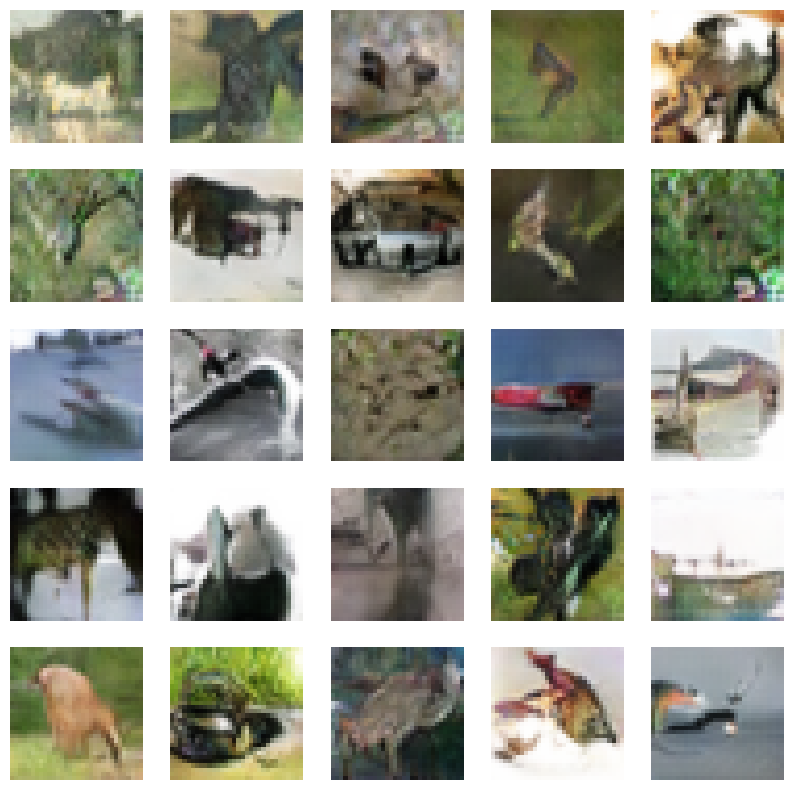

In [ ]:
def generate_images(generator_model, latent_dim, n_samples, labels):
    # Generate points in latent space
    latent_points, sample_labels = generate_latent_points(latent_dim, n_samples)
    # Update latent points with provided labels
    sample_labels[:] = labels
    # Generate images
    images = generator_model.predict([latent_points, sample_labels])
    # Scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    # Plot images
    plt.figure(figsize=(10, 10))
    for i in range(n_samples):
        plt.subplot(int(np.sqrt(n_samples)), int(np.sqrt(n_samples)), 1 + i)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

# Example usage
generate_images(g_model, latent_dim, n_samples=25, labels = 0)